## Introducción al Aprendizaje de Máquinas: Clasificación. 

Aprendizaje de Máquinas. Modelos de Aprendizaje Supervisado de Clasificación.

### Objetivos Notebook Introducción al Aprendizaje de Máquinas Clasificación:

1. Proveer un ejemplo de aprendizaje de máquinas supervisado como lo es identificar una señal de compra y una señal de venta de acciones.
2. Mostrar en líneas generales como esta implementada la simulación de la serie del tipo de cambio EUR-Dólar.

### Índice. 

#### 1. Indicadores de Análisis Técnico. 
#### 2. Backtesting Estrategía.
#### 3. Simulación de la tasa de cambio usando el movimiento browniano geométrico. 
#### 4. Referencias.

#### 1. Índicadores de Análisis Técnico.  

En la librería de Technical Indicators disponible en el siguiente respositorio: https://github.com/MesaFlar/FLAR_Quant_Lib se han venido codificando algunos de los siguientes indicadores de análisis técnico:  

- MACD Oscillator. 
- Bandas de Bollinger.
- Índice de fuerza relativa.

Estos indicadores de análisis técnico se los puede considerar métodos de Clasificación en la medida de que se aplican sobre datos cuya variable de respuesta tienen una etiqueta. Si la estrategía obtuvo un retorno positivo o un retorno negativo en el horizonte. 

En el presente notebook se aplicarán los modelos de análisis técnico para encontrar señales de compra o venta de las tasas de cambio de USD a GBP y EUR a GBP. 


Nota: Para correr este notebook en colab, es nesesario crear una carpeta llamada **datos** y dentro de ella agregar el archivo **"forex_data.csv"**. Puede descargarlo del repositorio de GitHub [CEFA 2025 - Repositorio](https://github.com/RepoDF/CEFA2025) o desde el siguiente Drive [CEFA 2025 Datos Notebooks](https://drive.google.com/drive/folders/1JY-Dy7kaSLINKBK4HDOV6fyLKa7R_1Zm?usp=drive_link).

In [200]:
# Instalar las librerías en el entorno de ejecución
%pip install scipy matplotlib pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [201]:
# Celda para importar las series de las tasas de cambio desde yahoo finance. 
# Las siguientes Líneas de código nos permiten importar los datos de las monedas para después exportarlos en el archivo forex_data.csv 
# ticker = ["EURUSD=X", "GBPUSD=X"]
# forex_df = yf.download(ticker, start="2020-01-01", end="2025-02-14", interval="1d")
# forex_df = forex_df.loc[:, idx['Close',:]]
# forex_df = forex_df.droplevel(0, axis=1)
# forex_df.columns = ["GBPUSD", "EURUSD"]
# forex_df.to_csv("forex_data.csv")

In [202]:
# Importamos las librerías que necesitamos para el notebook
import os
from scipy import stats
from scipy.stats import kstest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Get the Kolmogorov Smirnov threshold. 
from scipy.stats import kstwobign

idx = pd.IndexSlice 

In [203]:
# MACD Indicators
def calculate_simple_moving_average(close, n):
    """
    Calculates the simple moving average.
    
    Parameters
    ----------
    Close : DataFrame
        Close prece for every ticker and date
    
    n : int
        window size for the moving average computation

    Returns
    -------
    sma : DataFrame
      Simple movig average
    
    """
    
    
    sma = close.rolling(window = n).mean()
    

    return sma

In [204]:
# Bollinger Band Indicators
def calculate_simple_moving_sample_stdev(close, n):
    """
    Calculates the simple moving standard deviation.
    
    Parameters
    ----------
    Close : DataFrame
        Close prece for every ticker and date
    
    n : int
        window size for the moving average computation

    Returns
    -------
    sma : DataFrame
      Simple movig standard deviation
    
    """
    #TODO: Implement function
    
    smsd = close.rolling(window = n).std()
    

    return smsd

In [205]:

def create_bollinger_band_signal(close, n):
    
    """
    Create a meanreverting-based signal based on the upper and lower 
    bands of the Bollinger bands. Geenerate a buy sigal when the price 
    is bellow the lower band and a sell signal when the price is above
    the uper band.

    
    Parameters
    ----------
    Close : DataFrame
        Close price for every ticker and date
    
    n: int
       window size for the moving average and standard deviation computation
    
    Returns
    -------
    Signals : DataFrame
      Buy (1) Sell (-1) or do nothing signal (0)
    """
    
    sma = calculate_simple_moving_average(close,n)
    stdev = calculate_simple_moving_sample_stdev(close, n)
    upper = sma + 2*stdev
    lower = sma - 2*stdev
    
    sell = close > upper
    buy = close < lower
    
    signal = 1*buy - 1* sell
    
    return signal

In [206]:

def plot_bollinger_bands(df, column='Close', window=20):
    df.index = pd.to_datetime(df.index)

    """
    Plots Bollinger Bands with buy/sell signals and improved x-axis readability.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing price data.
    
    column : str
        Column name of the price data.
    
    window : int
        Rolling window size.

    Returns
    -------
    None
    """
    df = df.copy()
    
    # Generate signals and Bollinger Bands
    signal, sma, upper, lower = create_bollinger_band_signal_extensive(df[column], window)
    
    # Plot price and Bollinger Bands
    plt.figure(figsize=(12,6), dpi=100)  # Increase DPI for clarity
    plt.plot(df.index, df[column], label='Precio', color='blue', alpha=0.6)
    plt.plot(df.index, sma, label=f'{window}-Días SMA', color='black', linestyle='dashed')
    plt.fill_between(df.index, upper, lower, color='gray', alpha=0.2, label='Bollinger Bands')

    # Plot buy/sell signals
    plt.scatter(df.index[signal == 1], df[column][signal == 1], label='Buy Signal', marker='^', color='green', alpha=1)
    plt.scatter(df.index[signal == -1], df[column][signal == -1], label='Sell Signal', marker='v', color='red', alpha=1)

    # Improve x-axis formatting
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto spacing
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format dates
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability

    plt.legend()
    plt.title(f'Bandas de Bollinger ({window}-Días) con señales de trading')
    plt.xlabel('Fecha')
    plt.ylabel('Price')
    plt.grid(True, linestyle='--', alpha=0.5)  # Add a light grid
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

In [207]:

def create_bollinger_band_signal_extensive(close, n):
    """
    Create a meanreverting-based signal based on the upper and lower 
    bands of the Bollinger bands. Geenerate a buy sigal when the price 
    is bellow the lower band and a sell signal when the price is above
    the uper band.

    Parameters
    ----------
    Close : DataFrame
        Close price for every ticker and date
    
    n: int
       window size for the moving average and standard deviation computation
    
    Returns
    -------
    Signals : DataFrame
      Buy (1) Sell (-1) or do nothing signal (0)
    """
    sma = calculate_simple_moving_average(close, n)
    stdev = calculate_simple_moving_sample_stdev(close, n)
    upper = sma + 2 * stdev
    lower = sma - 2 * stdev

    sell = close > upper
    buy = close < lower

    signal = 1 * buy - 1 * sell

    return signal, sma, upper, lower

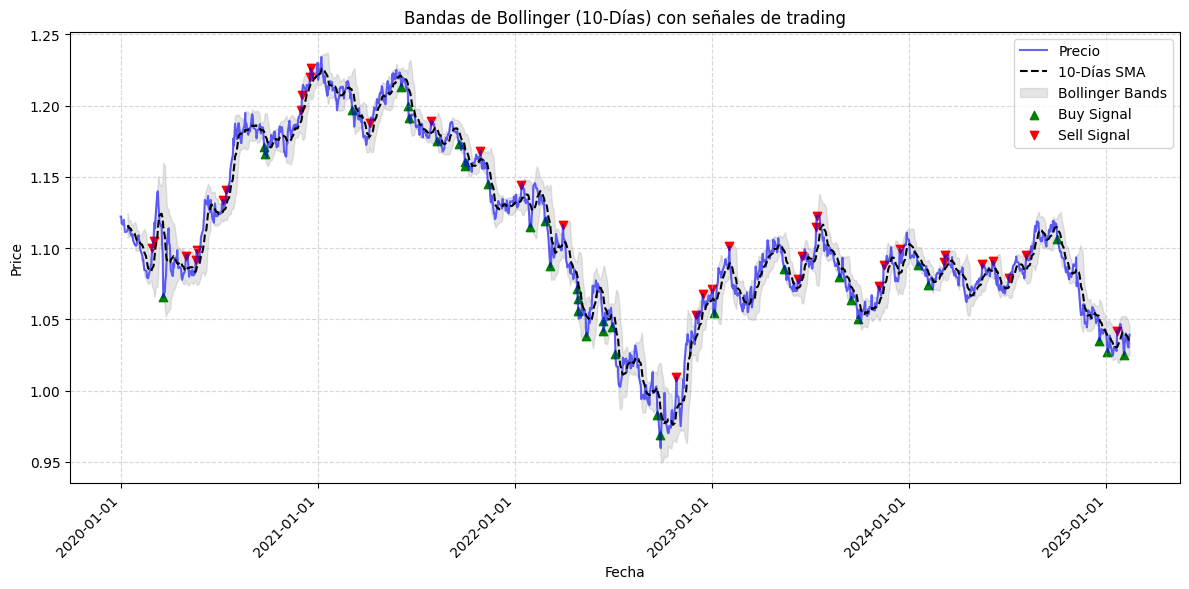

In [208]:
# Importamos entonces los datos de Forex.  

path = os.path.dirname(os.getcwd())

if path == '/': # Si estamos en la raíz del sistema, entonces no es necesario agregar la carpeta datos. (Aplica en Google Colab)
    file_path = os.path.join('datos', 'forex_data.csv')
else:
    file_path = os.path.join(path,'datos', 'forex_data.csv')
    
    
forex_df = pd.read_csv(file_path, sep=';', index_col=0, parse_dates=True)
    
# Eliminamos los nans de la base de datos de forex_df según corresponda.
forex_df = forex_df.dropna()

# Empezamos a usar la implementación de la librería create_bollinger_band_signal para encontrar las señales de compra y de venta. Usando una ventana de 10 días para constuir la bande de bolinger las señales.  
signal = create_bollinger_band_signal(forex_df[['EURUSD','GBPUSD']],10)

# Creamos una copia del DataFrame para poder graficar dicha banda de Bollinger. 
forex_df_plot = forex_df.copy()
plot_bollinger_bands(forex_df_plot, column = "EURUSD", window = 10 )

#### 2. Backtesting. 

Una vez tenemos las señales de compra y ventas debemos realizar el backtesting. Para ello se cuenta con las siguientes etapas. 

1. Calcular las estadísticas descriptivas de la estrategía. 

a. Filtrar las señales. Suprime señales repetidas dentro de una ventana de window_size días. Es decir, si dentro de un período de window_size días ya se ha dado una señal, descarta las siguientes señales de la misma dirección.   

b. Encontrar el retorno de la señal en el horizonte. 

c. Obtener las estadísticas descriptivas.

2. Calcular el test de Kolmogrov-Smirnov. 

a. Conferir formato al DataFrame con señales de compra y de venta. 

b. Aplicar test de Kolmogorov Smirnov. 

In [209]:
def clear_signals(signals, window_size):
    """
    Clear out signals in a Series of just long or short signals.
    
    Remove the number of signals down to 1 within the window size time period.
    
    Parameters
    ----------
    signals : Pandas Series
        The long, short, or do nothing signals
    window_size : int
        The number of days to have a single signal       
    
    Returns
    -------
    signals : Pandas Series
        Signals with the signals removed from the window size
    """
    # Start with buffer of window size
    # This handles the edge case of calculating past_signal in the beginning
    clean_signals = [0]*window_size
    
    for signal_i, current_signal in enumerate(signals):
        # Check if there was a signal in the past window_size of days
        has_past_signal = bool(sum(clean_signals[signal_i:signal_i+window_size]))
        # Use the current signal if there's no past signal, else 0/False
        clean_signals.append(not has_past_signal and current_signal)
        
    # Remove buffer
    clean_signals = clean_signals[window_size:]

    # Return the signals as a Series of Ints
    return pd.Series(np.array(clean_signals), signals.index)

In [210]:
def filter_signals(signal, lookahead_days):
    """
    Filter out signals in a DataFrame.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    filtered_signal : DataFrame
        The filtered long, short, and do nothing signals for each ticker and date
    """
    #TODO: Implement function
    
    long_signal = pd.DataFrame(0, columns = signal.columns, index = signal.index)
    short_signal = pd.DataFrame(0, columns = signal.columns, index = signal.index)
    filter_l = pd.DataFrame(0, columns = signal.columns, index = signal.index)
    filter_s = pd.DataFrame(0, columns = signal.columns, index = signal.index)
    long_signal[signal>0] = 1
    short_signal[signal<0] = 1
      
    #Iterate over columns of the signal DataFrame
      
    for i, column in enumerate(signal):
        filter_l.loc[:,column] = clear_signals(long_signal.loc[:,column], lookahead_days) 
        filter_s.loc[:,column] = -1*clear_signals(short_signal.loc[:,column], lookahead_days)    
    
    
    return filter_l + filter_s

In [211]:
def get_lookahead_prices(close, lookahead_days):
    """
    Get the lookahead prices for `lookahead_days` number of days.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------<  
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    """
    #TODO: Implement function
    lookahead_prices = close.shift(-lookahead_days)
    
    return lookahead_prices


In [212]:
def get_return_lookahead(close, lookahead_prices):
    """
    Calculate the log returns from the lookahead days to the signal day.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    
    Returns
    -------
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    """
    #TODO: Implement function
    lookahead_returns = np.log(lookahead_prices)-np.log(close)
    
    
    return lookahead_returns


In [213]:
def get_signal_return(signal, lookahead_returns):
    """
    Compute the signal returns.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    
    Returns
    -------
    signal_return : DataFrame
        Signal returns for each ticker and date
    """
    #TODO: Implement function
    
    signal_return = signal*lookahead_returns
    
    
    return signal_return

In [214]:
def calculate_kstest(long_short_signal_returns):
    """
    Calculate the KS-Test against the signal returns with a long or short signal.
    
    Parameters
    ----------
    long_short_signal_returns : DataFrame
        The signal returns which have a signal.
        This DataFrame contains two columns, "ticker" and "signal_return"
    
    Returns
    -------
    ks_values : Pandas Series
        KS static for all the tickers
    p_values : Pandas Series
        P value for all the tickers
    """
    #TODO: Implement function
    
    grouped_l_s = long_short_signal_returns.groupby('ticker')
    norm_arg = (np.mean(long_short_signal_returns), np.std(long_short_signal_returns,ddof = 0))

    ks = np.array([])
    p =  np.array([])
    i = np.array([])
    
    
    for name, group in grouped_l_s:
        ks = np.append(ks,kstest(group['signal_return'],'norm',norm_arg)[0])
        p =np.append(p,kstest(group['signal_return'],'norm',norm_arg)[1])
        i = np.append(i,name)
   
    ks_values = pd.Series(ks,index=i)
    p_values = pd.Series(p,index=i)
    
    return (ks_values, p_values)

In [215]:

def find_outliers(ks_values, p_values, ks_threshold, pvalue_threshold=0.05):
    """
    Find outlying symbols using KS values and P-values
    
    Parameters
    ----------
    ks_values : Pandas Series
        KS static for all the tickers
    p_values : Pandas Series
        P value for all the tickers
    ks_threshold : float
        The threshold for the KS statistic
    pvalue_threshold : float
        The threshold for the p-value
    
    Returns
    -------
    outliers : set of str
        Symbols that are outliers
    """
    #TODO: Implement function
    
    s = pd.Series(1,index=ks_values.index)
    outliers = s[(ks_values > ks_threshold) | (p_values < pvalue_threshold)]
    
    
    
    return set(outliers.index.values)

In [216]:
# 1. Calcular las Estadísticas Descriptivas de la Estrategía. 
# Filtra las señales.   
filtered_signals = filter_signals(signal, lookahead_days = 20)
filtered_signals

# Encontrar el retorno del índice/moneda en el horizonte.  
lookahead_prices = get_lookahead_prices(forex_df, lookahead_days = 20)

lookahead_return = get_return_lookahead(forex_df, lookahead_prices)

# Obtener el retorno de la señal en el horizonte. 
signal_returns = get_signal_return(filtered_signals, lookahead_return)

# Eliminar aquellas fechas donde no se puede calcular el retorno.
signal_returns = signal_returns.dropna()
signal_returns

# Obtener estadísticas descriptivas de la estrategía. 
signal_returns.iloc[:-1000,:].describe()

,EURUSD,GBPUSD
count,316.000000,316.000000
mean,-0.000218,0.000138
std,0.003260,0.004220
min,-0.045990,-0.040278
25%,0.000000,0.000000
50%,0.000000,-0.000000
75%,0.000000,0.000000
max,0.018696,0.045152


In [217]:
# 2. Filtrar señales de compra y de venta 
long_short_signal_returns = signal_returns[signal_returns != 0].stack()
long_short_signal_returns = long_short_signal_returns.reset_index().iloc[:, [1,2]]
long_short_signal_returns.columns = ['ticker', 'signal_return']
long_short_signal_returns

### Filtrar aquellas observaciones que no tengan una señal de compra o de venta 
long_short_signal_returns.index = long_short_signal_returns['ticker']
long_short_signal_returns = long_short_signal_returns.iloc[:,1:]
long_short_signal_returns

,signal_return
ticker,
GBPUSD,0.016608
EURUSD,-0.004630
GBPUSD,0.004923
EURUSD,0.018696
EURUSD,-0.012135
...,...
EURUSD,-0.022233
GBPUSD,-0.017867
GBPUSD,0.003203


Calculo Test de Kolmogorov-Smirnov.

In [218]:
### Obtener los valores del estadístico de Kolmogorov-Smirnov
ksvalues, p_values = calculate_kstest(long_short_signal_returns)
### Obtener el intervalo crítico del test de Kolmogorov-Smirnov. 
alpha = 0.05
critical_value = kstwobign.ppf(1 - alpha) / np.sqrt(len(long_short_signal_returns))
outliers = find_outliers(ksvalues, p_values, critical_value)
outliers

c:\Users\juanj\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


set()

Como podemos apreciar en general las estrategías no generan retornos que sean significativamente superiores a los de la tasa de cambio en cuestión.

#### 3. Simulación de la tasa de cambio usando el modelo del Movimiento Browniano Geométrico. 

Para realizar una simulación del movimiento de la tasa de cambio de libra a dólar, primero revisamos algunas características de serie. 

* Graficar precio ajustado de la tasa de cambio de Libra a Dólar.
* Graficar histograma con los retornos logarítmicos de la tasa de cambio Libra a dólar. 
* Coeficiente de correlación entre los retornos de la tasa de cambio en t y los retornos de la tasa de cambio en t-1. 
* Simulación de la serie usando el modelo de movimiento browniano geométrico.



In [219]:
def plot_time_series(series, title="Gráfico de Series de Tiempo", xlabel="Fecha", ylabel="Precio", 
                     date_format='%Y-%m-%d', tick_interval=None, figsize=(10, 5)):
    """
    Plots a time series with formatted datetime x-axis and returns the figure object.
    
    Parameters:
    - series: pandas Series with a datetime index
    - title: str, title of the plot
    - xlabel: str, label for x-axis
    - ylabel: str, label for y-axis
    - date_format: str, format for date labels (default: '%Y-%m-%d')
    - tick_interval: int, optional, interval for showing x-axis ticks
    - figsize: tuple, figure size
    
    Returns:
    - fig: Matplotlib figure object
    """
    fig, ax = plt.subplots(figsize=figsize)
    series.plot(ax=ax, title=title)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    # Format date labels
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))
    
    # Set tick interval if provided
    if tick_interval:
        ax.set_xticks(series.index[::tick_interval])
    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)
    
    return fig  # Return the figure object

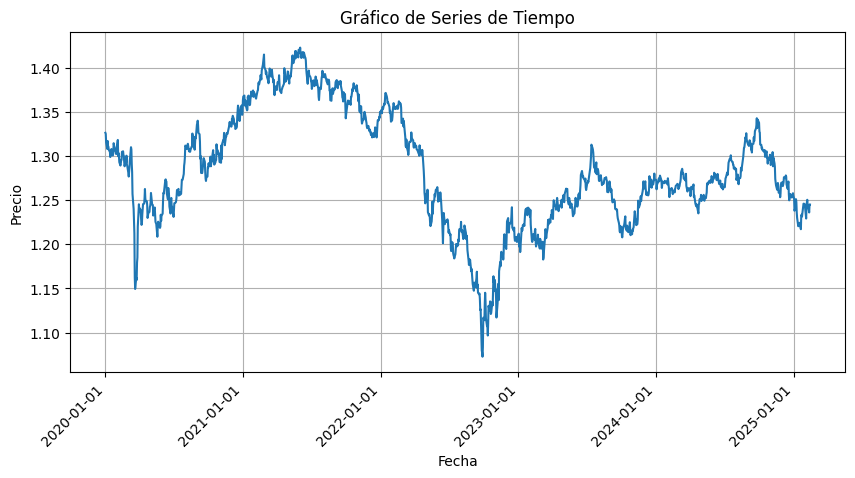

In [220]:
### Realizamos una segregación de la tasa de cambio libra a dólar.
GBP_USD = forex_df.loc[:,'GBPUSD']

### Obtenemos una copia de la serie para propositos del gráfico.
GBP_USD_plot = GBP_USD.copy() 
GBP_USD_plot.index = pd.to_datetime(GBP_USD_plot.index)
GBP_USD_plot

# 
fig = plot_time_series(GBP_USD_plot)
plt.show()

In [221]:
def calculateLogReturns(df): 
    return np.log((df.shift(-1)/df).shift(1))

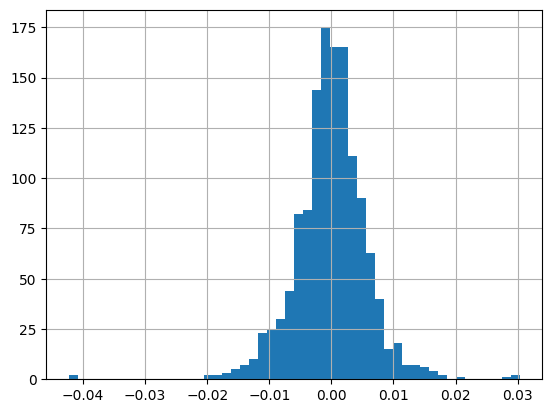

In [222]:
### Histograma de los retornos del tipo de cambio libra a dólar. 
log_returns_GBPUSD = calculateLogReturns(GBP_USD)
log_returns_GBPUSD.hist(bins = 50).plot()
plt.show()

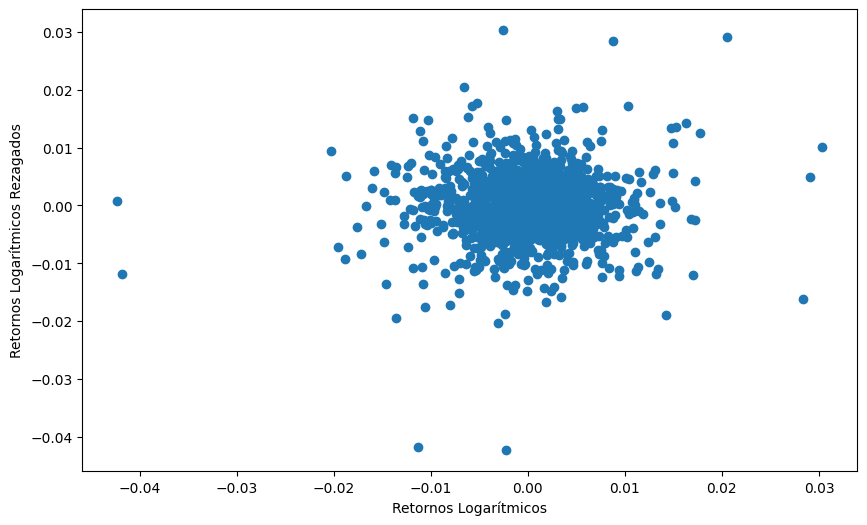

In [223]:
### Diagrama de dispersión de los retornos de los activos 

log_returns_GBPUSD_lagged = log_returns_GBPUSD.shift()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(log_returns_GBPUSD, log_returns_GBPUSD_lagged)
plt.xlabel('Retornos Logarítmicos')
plt.ylabel('Retornos Logarítmicos Rezagados')
plt.show()

In [224]:
# Coeficiente de correlación entre los retornos actuales y los rezagados
correlation = log_returns_GBPUSD.corr(log_returns_GBPUSD_lagged)
print(f"Correlation coefficient: {correlation}")
# Como vemos el coeficiente de correlación dió muy cercano a cero indicando que efectivamente no hay correlación entre los retornos de hoy y los retornos 
# de ayer. 

Correlation coefficient: 0.03657689610319706


### 4. Simulación del precio de la tasa de cambio con modelo de movimiento browniano geométrico. 

Tomando la serie de la tasa de cambio de Libra a Dólar.

* Graficar precio ajustado de la tasa de cambio de Libra a Dólar.
* Graficar histograma con los retornos logarítmicos de la tasa de cambio Libra a dólar. 
* Realizar un diagrama de dispersión de la rentabilidad en el día t-1 vs la rentabilidad del día t. Calcular el coeficiente de correlación entre los mismos. 
* Realice una simulación usando el modelo de movimiento browniano geométrico 

Usando la siguiente definición de la ecuación del movimiento browniano. 

$dS_{t} = uS_{t}dt+\sigma S_{t}  d W_{t}$

Se puede llegar a la siguiente solución analítica para el precio spot del movimiento browniano geométrico. 

$ S_t = S_{0}(e^{(u -\frac{\sigma^{2}}{2})t + \sigma W_{t}}) $

In [225]:
# Coeficiente de drift
mu = log_returns_GBPUSD.mean()
# Número de pasos
n = 252
# Tiempo en años. 
T = 1
# Número de simulaciones.
M = 100
# Precio inicial de la acción. 
S0 = GBP_USD.iloc[-1]
# Volatilidad
sigma = log_returns_GBPUSD.std()
# Print the inputs 
print(mu, sigma)

-4.732139591000227e-05 0.0057572515453151235


In [226]:
### Imprimimos entonces los parámetros del movimiento browniano geométrico: 
### Retorno Anualizado. 
### Volatilidad Anualizada. 
print(mu*np.sqrt(252), log_returns_GBPUSD.std()*np.sqrt(252))

-0.0007512038716217704 0.09139353494487677


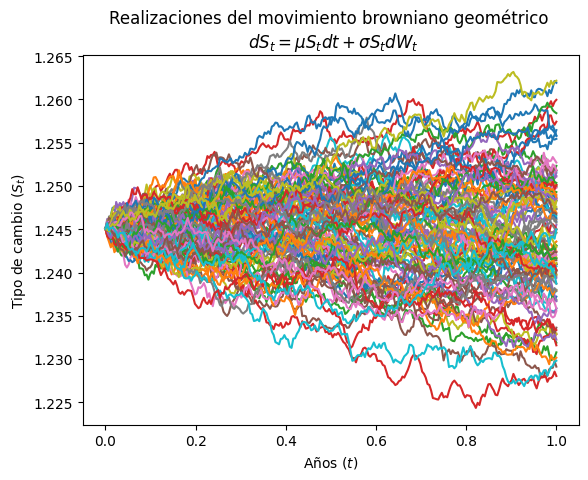

In [227]:
# calc each time step
dt = T/n

# simulation using numpy arrays
St = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(M,n)).T
)

# include array of 1's
St = np.vstack([np.ones(M), St])

# multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0). 
St = S0 * St.cumprod(axis=0)

# Define time interval correctly 
time = np.linspace(0,T,n+1)

# Require numpy array that is the same shape as St
tt = np.full(shape=(M,n+1), fill_value=time).T

plt.plot(tt, St)
plt.xlabel("Años $(t)$")
plt.ylabel("Tipo de cambio $(S_t)$")
plt.title(
    "Realizaciones del movimiento browniano geométrico \n $dS_t = \mu S_t dt + \sigma S_t dW_t$"
)
plt.show()

### Referencias

Simulating Geometric Brownian Motion (GBM) in Python, QuantPy. (n.d.). Retrieved from https://quantpy.com.au/stochastic-calculus/simulating-geometric-brownian-motion-gbm-in-python/

Leong, L. (2022, January 19). How to test if trading algorithm performance is deteriorating. Gradient Growth. https://medium.com/gradient-growth/how-to-test-if-trading-algorithm-performance-is-deteriorating-30d469056a04

https://github.com/eduardohoc/Technical-Analysis-and-Backtest-Functions
